# <b>1.1 Introduction</b>
The project is based on sales forecasting. Indeed, we have been provided with aggregated weekly-recorded information for different products (_SKU_) throughout a 3  years time window, from December 2016 to December 2019. W
e are asked to forecast the weekly sales regarding 12 of the 43 products in the dataset. <br>
The metric that we are going to use to estimate the goodness of our predictions is the Mean Average Percentage Error (_MAPE_).

Here a quick glance to the dataset and to the time series:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append("../")

csv_train = pd.read_csv("../dataset/original/train.csv")
csv_test = pd.read_csv("../dataset/original/x_test.csv")

from preprocessing.preprocessing import convert_date 
convert_date(csv_train.copy()).head()

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,2689,SINGLE,395.41,BRAND1,1.16,NaN,NaN,NaN,0,24175.0
1,2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0
2,2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0
3,2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0
4,2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0


---
# <b>1.2 Data Preprocessing</b>
First of all, we have decided how to deal with the NaNs in the train and we have chosen to impute them for the first week. <br>
Moreover, we have found useful to convert the values of **_sales w-1_** and **_target_** to the logarithm to smooth and flatten the range which the predictions belong to. The reason of this choice is that it performs better with _decisions trees_, which are some of the model that we are going to show.  
In the end, we have attached to the whole dataframe the column **_real_target_** with the target that we have to predict for that specific week.

In [3]:
from preprocessing.preprocessing import preprocessing, inverse_interpolation
df_prepr = preprocessing(csv_train.copy(), csv_test.copy())
df_prepr

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,real_target
0,2016-12-10,144,0,114.23,1,2.18,73.0,100.000000,10.497091,1,10.845855,51320.0
1,2016-12-17,144,0,114.23,1,2.00,45.0,100.000000,10.845855,1,11.103934,66431.0
2,2016-12-24,144,0,114.23,1,2.05,17.0,100.000000,11.103934,1,10.950842,57001.0
3,2016-12-31,144,0,114.23,1,3.00,2.0,100.000000,10.950842,1,9.619333,15052.0
4,2017-01-07,144,0,114.23,1,2.99,2.0,28.534193,9.619333,1,9.999570,22016.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6014,2019-05-25,2718,1,395.41,0,1.11,0.0,26.050480,10.430462,0,10.414183,33328.0
6015,2019-06-01,2718,1,395.41,0,1.30,1.0,43.099496,10.414183,0,10.021848,22512.0
6016,2019-06-08,2718,1,395.41,0,1.55,0.0,0.000000,10.021848,0,9.767782,17461.0
6017,2019-06-15,2718,1,395.41,0,1.55,0.0,0.000000,9.767782,0,9.747185,17105.0


Another important decision taken has been the choice to increase the number of data. Dealing with decision trees is better to have a lot of samples and we saw some improvements with **data augmentation**. So, taking weeks of 2017 and 2018, giving them for each sample some random weights, we have created a realistic 2016, also handling pretty well overfitting. This will be also useful with a stacking approach.

In [6]:
df_augmented = preprocessing(csv_train.copy(), csv_test.copy(), useTest=False, dataAugmentation=True)
df_augmented.sort_values(['Date', 'sku'])

,Date,sku,pack,size (GM),brand,scope,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,target,real_target
0,2016-01-09,144,0,114.23,1,1,2.477123,0.749080,10.687200,10.625524,10.385478,32384.873910
206,2016-01-09,546,1,114.23,1,1,0.521210,0.000000,23.270807,11.082541,11.215172,74247.469248
412,2016-01-09,549,1,114.23,1,1,0.513697,0.000000,28.422655,10.558518,10.528154,37351.447480
618,2016-01-09,554,1,114.23,1,1,0.529836,0.983593,26.447851,11.517068,11.647277,114378.496424
824,2016-01-09,686,0,125.65,3,1,2.164150,0.040493,0.187194,10.280214,10.683218,43616.706235
...,...,...,...,...,...,...,...,...,...,...,...,...
1647,2019-12-14,1035,1,114.23,1,1,0.550000,6.000000,36.060336,10.547655,NaN,NaN
1853,2019-12-14,1051,0,125.65,3,1,2.990000,0.000000,100.000000,10.110420,NaN,NaN
2059,2019-12-14,1058,1,125.65,3,1,0.560000,0.000000,25.368425,10.232611,NaN,NaN
2265,2019-12-14,1065,1,125.65,3,1,0.570000,7.000000,37.921239,11.282971,NaN,NaN


In [7]:
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df_augmented.sku)), replace=False)

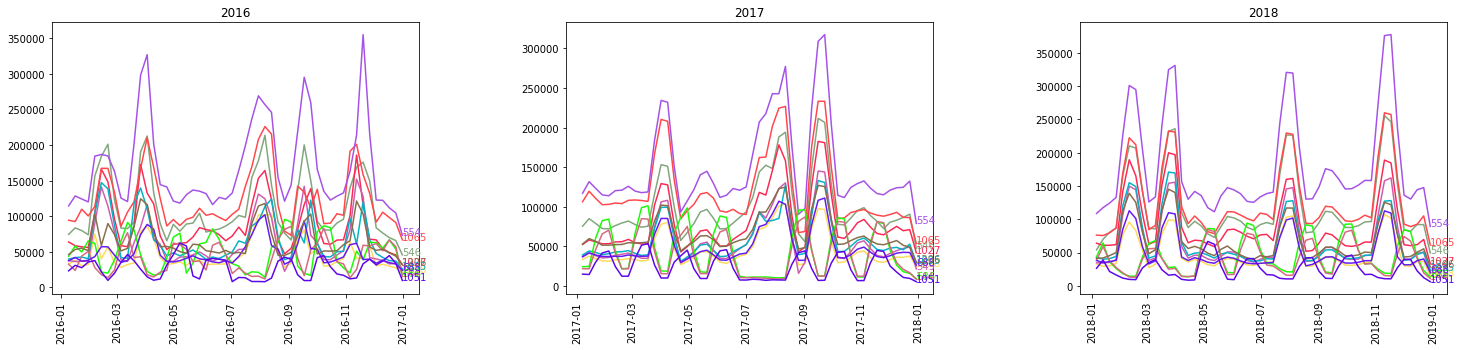

In [28]:
df_train_augmented = df_augmented[df_augmented.Date < '2019-06-29'] 
df_scope = df_train_augmented[df_train_augmented.scope == 1]

fig = plt.figure(figsize=(25,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for n, year in enumerate(set(df_train_augmented[df_train_augmented.Date.dt.year < 2019].Date.dt.year)):
    ax = fig.add_subplot(1, 3, n+1)
    plt.xticks(rotation=90)
    df_year = df_scope[df_scope.Date.dt.year == year]
    ax.set_title(str(year))
    
    for i,s in enumerate(set(df_year.sku)):
        ax.plot(df_year[df_year.sku == s].Date, df_year[df_year.sku == s]['real_target'], color=mycolors[i])
        last_x, last_y = df_year[df_year.sku == s].Date.values[-1], df_year[df_year.sku == s]['real_target'].values[-1]
        plt.text(last_x, last_y, str(s), color=mycolors[i])

As we can see from the previous plots, we have reproduced the 2016 taking into account the behaviours of other years. In fact, we can notice that the peaks of 2016 follow quite well ones of 2017 and 2018, without being too precise, and for this reason it seems to have a reasonable evolution. 

For the tuning and the model evaluation we have had the need to use a **validation set**. <br>
For its creation we have decided to take the 10% of the original train. Since we are dealing with time series, we have tought to exploit as much as possible the more recent data, so we have chosen to predict week-by-week, appending the current prediction to the train and thining more and more the validation set (in practice, a sort of crossvalidation).

In [5]:
from preprocessing.preprocessing import train_validation_split, preprocessing
df = preprocessing(csv_train.copy(), csv_test.copy(), useTest=False)
df_t = df[~df.target.isna()]
df_train, df_val, val_dates = train_validation_split(df_t, k=0.10)
df_val = df_val.sort_values(['Date', 'sku'])
df_val

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,real_target
115,2019-02-23,144,0,114.23,1,3.49,1.0,4.215402,9.812632,1,9.502039,13386.0
273,2019-02-23,546,1,114.23,1,0.34,19.0,95.813853,12.344068,1,12.434021,251203.0
431,2019-02-23,549,1,114.23,1,0.31,21.0,99.893335,11.940054,1,11.989091,160988.0
589,2019-02-23,554,1,114.23,1,0.35,37.0,93.944760,12.728710,1,12.810137,365907.0
747,2019-02-23,686,0,125.65,3,3.48,0.0,2.530391,9.977017,1,9.827470,18535.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5486,2019-06-22,2705,1,131.80,0,0.58,0.0,0.738641,11.301883,0,11.295926,80492.0
5619,2019-06-22,2707,1,439.34,0,1.50,10.0,55.944352,10.540329,0,10.512383,36767.0
5752,2019-06-22,2711,1,395.41,0,1.09,0.0,0.000000,8.676928,0,9.365548,11678.0
5885,2019-06-22,2712,1,395.41,0,1.09,0.0,0.000000,9.350015,0,10.108345,24546.0
